In [1]:
import sys
sys.path.insert(1,'../')

import numpy as np
from scipy.io import loadmat
from event_rate_first import *
from wf_similarity_measures import *
import matplotlib.pyplot as plt
import time

-------------
# Load wavefroms files and preprocess
-------------

In [2]:
print()
print('Loading matlab files...')
print()
wf_name = '../../matlab_files/gg_waveforms-R10_IL1B_TNF_03.mat'
ts_name = '../../matlab_files/gg_timestamps.mat'

waveforms = loadmat(wf_name)
#print(f' keys of matlab file: {waveforms.keys()}')
waveforms = waveforms['waveforms']
timestamps = loadmat(ts_name)['gg_timestamps']
print('MATLAB files loaded succesfully...')
print()
print(f'Shape of waveforms: {waveforms.shape}.')
print()
print(f'Shape of timestamps: {timestamps.shape}.')
print()
assert waveforms.shape[0] == timestamps.shape[0], 'Missmatch of waveforms and timestamps shape.'
std_waveforms = standardise_wf(waveforms)


Loading matlab files...

MATLAB files loaded succesfully...

Shape of waveforms: (136259, 141).

Shape of timestamps: (136259, 1).



------------------
# Setting Parameters
------------------

In [8]:
# ------------------------------------------------------------------------------------
# --------------------- Test out Event-rate labeling: ----------------------------
# ------------------------------------------------------------------------------------
threshold = 0.7
runs_for_time = 0
path_to_fig = None # '../Figs_TESTS/correlation_meassure_relates/WF_thres_'+str(threshold)+'_wf_'+str(i)+'.png'
path_to_fig_ev = None # '../Figs_TESTS/correlation_meassure_relates/EV_thres_'+ str(threshold) +'_wf_' + str(i)+'.png'



first_injection_time = 30*60
second_injection_time = 60*60
# Different periods of recordings in index 
idx_pre_injection = np.argwhere(timestamps[:,0] < first_injection_time)
idx_post_first = np.argwhere((first_injection_time < timestamps[:,0]) & (timestamps[:,0] < second_injection_time))
idx_post_second = np.argwhere(timestamps[:,0] > second_injection_time)
#std_waveforms[timestamps[:,0] < first_injection_time].nonzero()[-1]

idx_pre_injection.shape

(60498, 1)

In [4]:
wf_post_first = std_waveforms[(first_injection_time < timestamps[:,0]) & (timestamps[:,0] < second_injection_time)] 
wf_post_second = std_waveforms[timestamps[:,0] > second_injection_time] 

ts_pre_injection = timestamps[timestamps[:,0] < first_injection_time] 
ts_post_first = timestamps[(first_injection_time < timestamps[:,0]) & (timestamps[:,0] < second_injection_time)] 
ts_post_second = timestamps[timestamps[:,0] > second_injection_time] 

# Test runs to find hyperparameters for threshold etc. 

Average time to label a cluster about 5 ms. 

[60498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=60498 : 903.


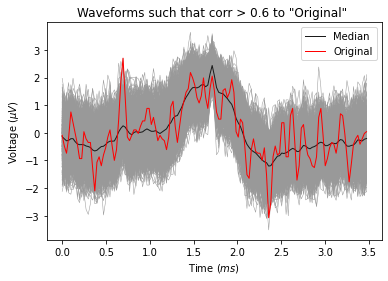

No given noise..


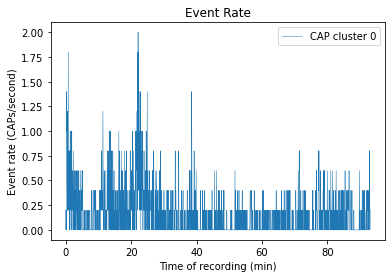

[61498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=61498 : 832.


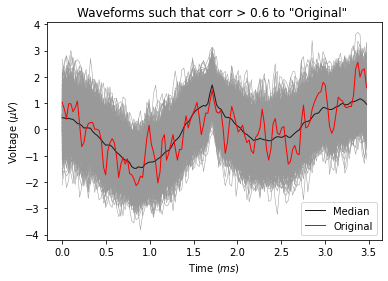

No given noise..


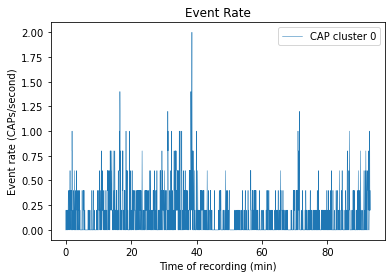

[62498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=62498 : 1414.


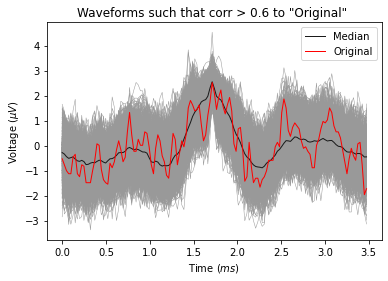

No given noise..


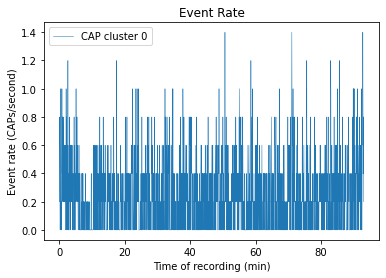

[63498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=63498 : 29.


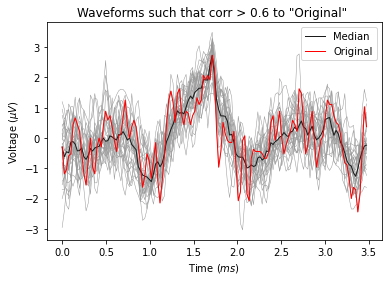

No given noise..


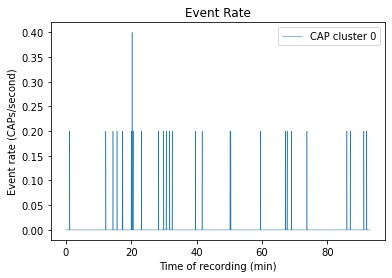

[64498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=64498 : 125.


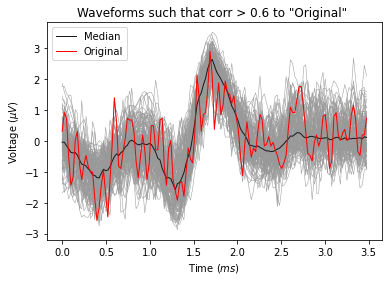

No given noise..


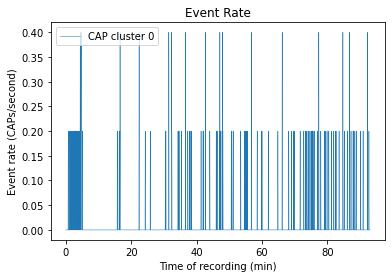

[65498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=65498 : 4255.


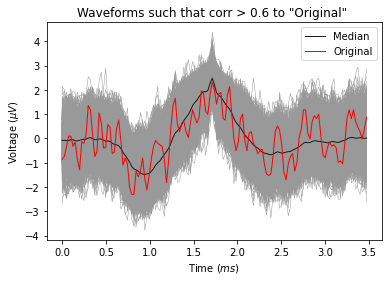

No given noise..


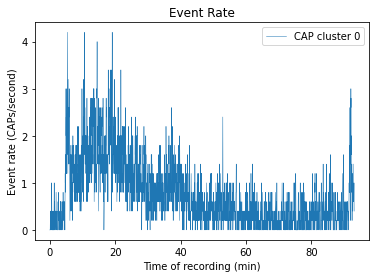

[66498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=66498 : 4237.


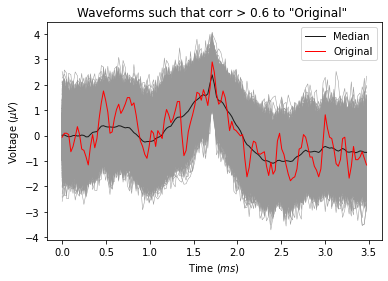

No given noise..


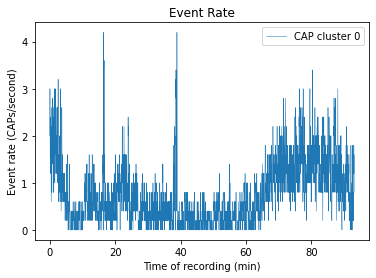

[67498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=67498 : 31608.


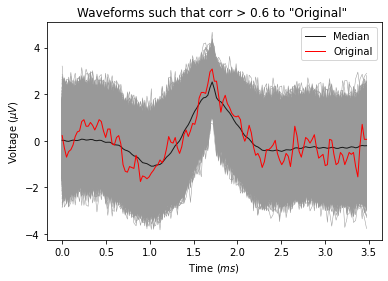

No given noise..


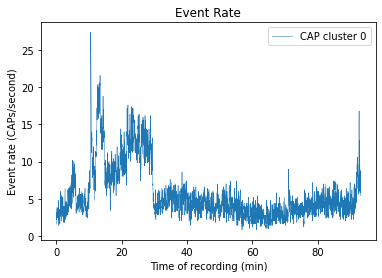

[68498]
The event_rate_label is : [[1.]
 [0.]
 [0.]]

Number of waveforms above threshold for wf_idx=68498 : 3.


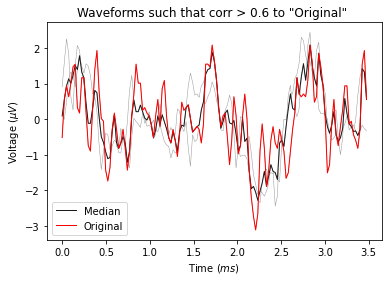

No given noise..


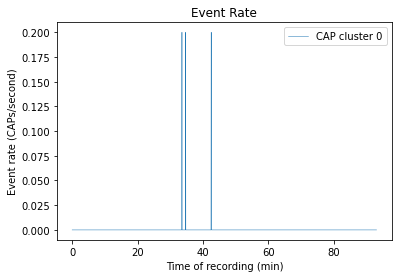

[69498]
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=69498 : 12534.


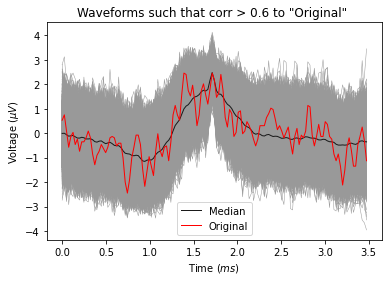

No given noise..


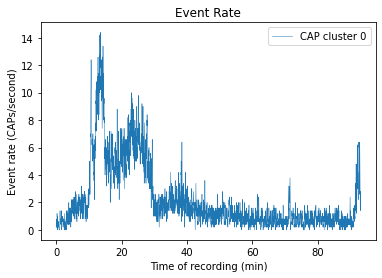

In [10]:
for threshold in [0.6]:
    for i in idx_post_first[0:10000:1000]: #range(20,100,20):
        print(i)
        i = i[0]
        correlations = wf_correlation(i,std_waveforms)
        bool_labels = label_from_corr(correlations,threshold=threshold,return_boolean=True )
        event_rates, real_clusters = get_event_rates(timestamps,bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates)
        ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        print(f'The event_rate_label is : {ev_labels}')
        print()
        plot_correlated_wf(i,std_waveforms,bool_labels,threshold,saveas=path_to_fig,verbose=True )
        plot_event_rates(event_rates,timestamps,noise=None,conv_width=20,saveas=path_to_fig_ev, verbose=True)

# Actually label waveforms with event rate change after injection time
That is: 
- Standardise waveforms
- Calculate correlation $\rho_{ij}$ between each waveform
- Consider waveforms as "similar" if $\rho_{ij} > THRES$, for some threshold ($THRES=0.6$). Label these into a cluster with label 1, otherwise 0.
- Calculate event rate for the 1-cluster.
- Caclate the change in event rate after injections $\{ \Delta EV_i\}_{i=1}^2$, and consider it sufficient if $\Delta EV_i > \sigma_{ev_i}$, where $\sigma_{ev_i}$ is the standard deviation during the "baseline" period. That is, the time before each injection. 

In [7]:
threshold=0.6
n_landing = 1000

ev_labels = np.empty((3,waveforms.shape[0]))

ii = 0

start_t = time.time()
prev_landing = 0
for landing in np.arange(0,waveforms.shape[0],n_landing):
    i_range = np.arange(prev_landing,landing)
    correlations = wf_correlation(i_range,std_waveforms)
    for corr_vec in correlations.T:
        bool_labels = label_from_corr(corr_vec,threshold=threshold,return_boolean=True)
        event_rates, real_clusters = get_event_rates(timestamps[:,0],bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates)
        #ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        ev_labels[:,ii] = ev_label(delta_ev,ev_stats,n_std=1)[:,0]
        ii +=1
    prev_landing = landing
    if ii%10000=0:
        print(f'Time for {ii} labels : {time.time()-start_t}')
    

Time for 0 labels : 0.015260934829711914
Time for 1000 labels : 3.7326579093933105
Time for 2000 labels : 7.2980029582977295
Time for 3000 labels : 10.85506272315979
Time for 4000 labels : 14.457977771759033
Time for 5000 labels : 18.062809705734253
Time for 6000 labels : 21.667343854904175
Time for 7000 labels : 25.41211700439453
Time for 8000 labels : 29.46151089668274
Time for 9000 labels : 34.37238574028015
Time for 10000 labels : 38.881393909454346
Time for 11000 labels : 43.27684569358826
Time for 12000 labels : 47.15502071380615
Time for 13000 labels : 51.113290786743164
Time for 14000 labels : 55.19151163101196
Time for 15000 labels : 58.797656774520874
Time for 16000 labels : 63.104076623916626
Time for 17000 labels : 67.5893828868866
Time for 18000 labels : 71.62808680534363
Time for 19000 labels : 75.57282781600952
Time for 20000 labels : 79.77096390724182
Time for 21000 labels : 84.55606770515442
Time for 22000 labels : 89.31413888931274
Time for 23000 labels : 93.304670810

-----
# Looking at the resulting labels from above: 
-----

In [19]:
np.sum(ev_labels,axis=-1)
ev_increase_first = np.argwhere(ev_labels[0,:]==1)
ev_increase_second = np.argwhere(ev_labels[1,:]==1)

Number of waveforms above threshold for wf_idx=261 : 7363.


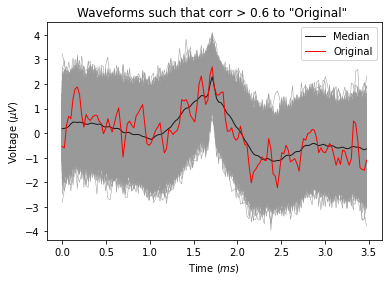

No given noise..


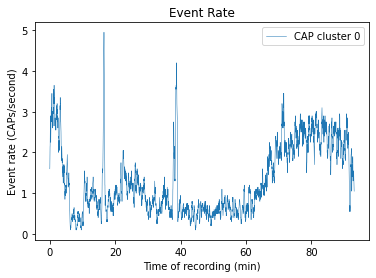

Number of waveforms above threshold for wf_idx=30574 : 10895.


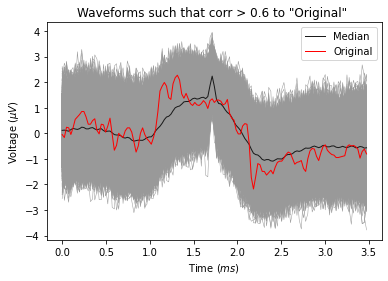

No given noise..


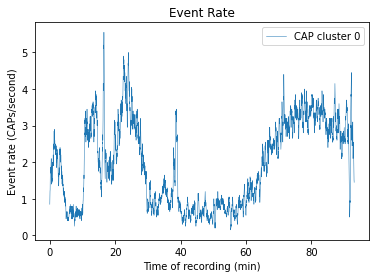

Number of waveforms above threshold for wf_idx=73912 : 9810.


/Users/Gabriel/miniconda3/envs/tf2/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


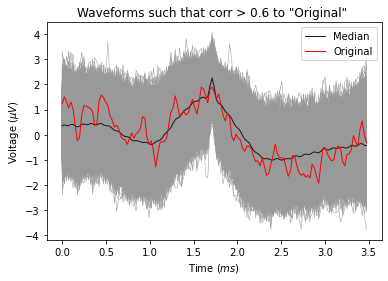

No given noise..


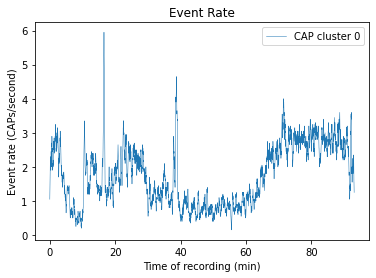

Number of waveforms above threshold for wf_idx=90559 : 1722.


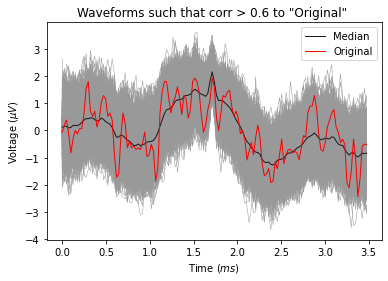

No given noise..


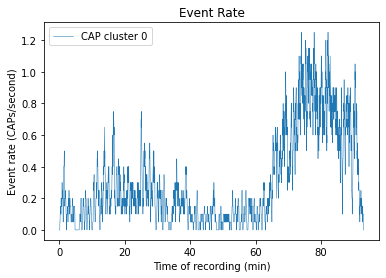

Number of waveforms above threshold for wf_idx=102526 : 7650.


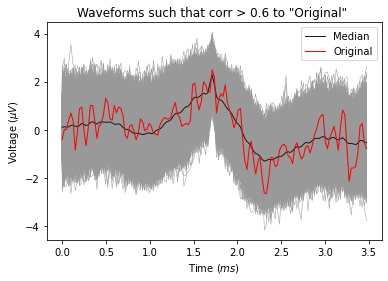

No given noise..


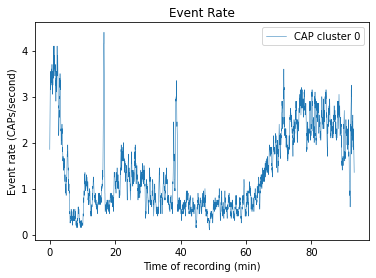

Number of waveforms above threshold for wf_idx=105846 : 2985.


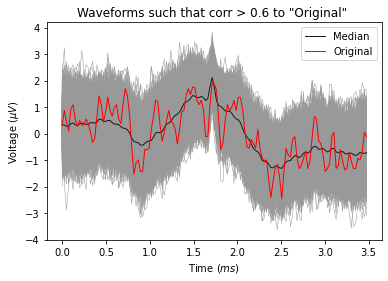

No given noise..


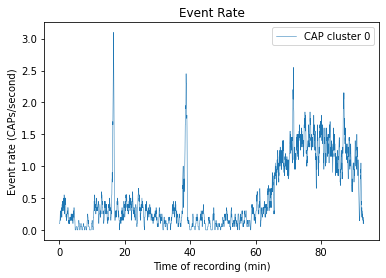

Number of waveforms above threshold for wf_idx=107761 : 10677.


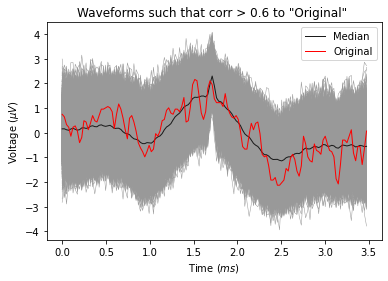

No given noise..


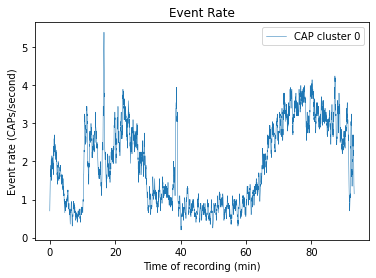

Number of waveforms above threshold for wf_idx=109002 : 6474.


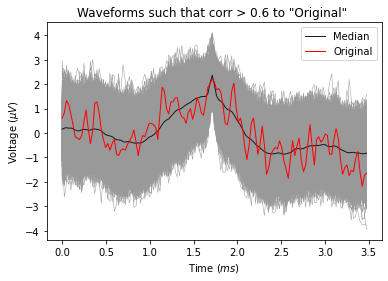

No given noise..


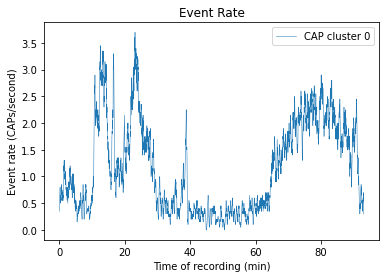

In [22]:
for threshold in [0.6]:
    for i in ev_increase_second[0:800:100]: #range(20,100,20):
        #print(i)
        i = i[0]
        correlations = wf_correlation(i,std_waveforms)
        bool_labels = label_from_corr(correlations,threshold=threshold,return_boolean=True )
        #print(f'Number of waveforms above threshold for wf_idx={i} : {sum(bool_labels)}.')        #event_rates, real_clusters = get_event_rates(timestamps,bool_labels,bin_width=1,consider_only=1)
        event_rates, real_clusters = get_event_rates(timestamps[:,0],bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates)
        ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        #print(f'The event_rate_label is : {ev_labels}')
        #print()
        #fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)
        plot_correlated_wf(i,std_waveforms,bool_labels,threshold,saveas=None,verbose=True )
        plot_event_rates(event_rates,timestamps,noise=None,conv_width=20,saveas=None, verbose=True)

----
# Same as above but using dct transform
----

In [5]:
# ------------------------------------------------------------------------------------
# --------------------- Test out Event-rate labeling: ----------------------------
# ------------------------------------------------------------------------------------
threshold = 0.7
runs_for_time = 0
path_to_fig = None # '../Figs_TESTS/correlation_meassure_relates/WF_thres_'+str(threshold)+'_wf_'+str(i)+'.png'
path_to_fig_ev = None # '../Figs_TESTS/correlation_meassure_relates/EV_thres_'+ str(threshold) +'_wf_' + str(i)+'.png'



first_injection_time = 30*60
second_injection_time = 60*60
# Different periods of recordings in index 
idx_pre_injection = np.argwhere(timestamps[:,0] < first_injection_time)
idx_post_first = np.argwhere((first_injection_time < timestamps[:,0]) & (timestamps[:,0] < second_injection_time))
idx_post_second = np.argwhere(timestamps[:,0] > second_injection_time)
#std_waveforms[timestamps[:,0] < first_injection_time].nonzero()[-1]

idx_pre_injection.shape

(60498, 1)

In [45]:
from scipy import fft
N = 10
M = waveforms.shape[-1] # number of time-samples
m = 40

idx_to_consider = idx_pre_injection[99:300:100,:].reshape((3))
print(idx_to_consider.shape)
keep_m_coef = np.zeros((waveforms.shape))
dct_tests = waveforms
dct_wf = fft.dct(dct_tests,norm='ortho')
print(dct_wf.shape)
keep_m_coef[:,:m] = dct_wf[:,:m]
reconstruction = fft.idct(keep_m_coef,norm='ortho')
std_dct = standardise_wf(keep_m_coef)

(3,)
(136259, 141)


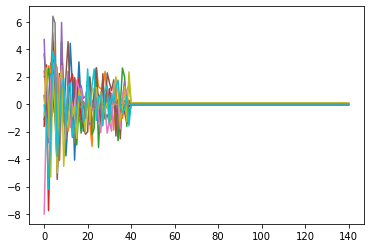

In [46]:
for i in range(0,100,10):
    plt.plot(std_dct[i])
plt.show()

99
0.14537622570768827
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=99 : 9.


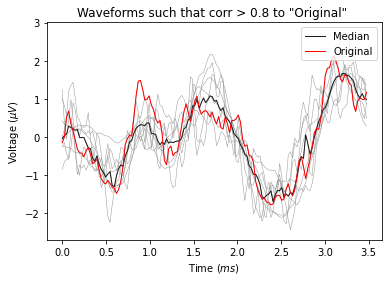

No given noise..


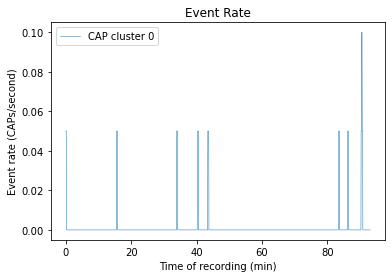

199
0.10666334919546072
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=199 : 21.


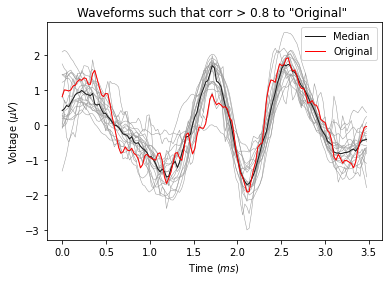

No given noise..


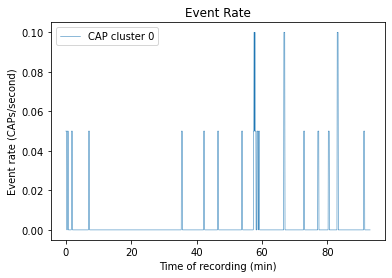

299
0.2778460391302751
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=299 : 1.


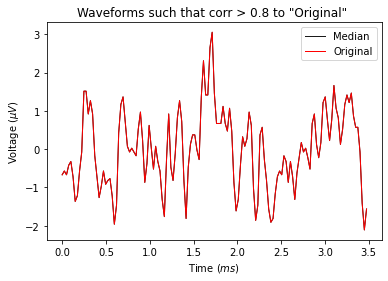

No given noise..


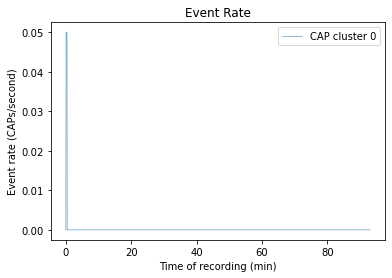

In [47]:

for threshold in [0.8]:
    for i in idx_to_consider: #range(20,100,20):
        print(i)
        correlations = wf_correlation(i,std_dct)
        print(np.mean(correlations))
        bool_labels = label_from_corr(correlations,threshold=threshold,return_boolean=True )
        
        event_rates, real_clusters = get_event_rates(timestamps,bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates)
        ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        print(f'The event_rate_label is : {ev_labels}')
        print()
        plot_correlated_wf(i,std_waveforms,bool_labels,threshold,saveas=path_to_fig,verbose=True )
        plot_event_rates(event_rates,timestamps,noise=None,conv_width=20,saveas=path_to_fig_ev, verbose=True)

-----
# Test of translation - invariance:
----

[130 131 132 133 134 135 136 137 138 139 140   0   1   2   3   4   5   6
   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129]


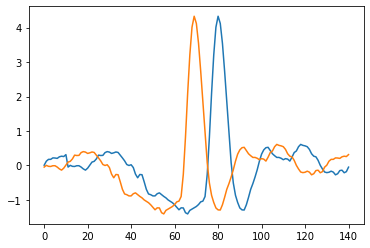

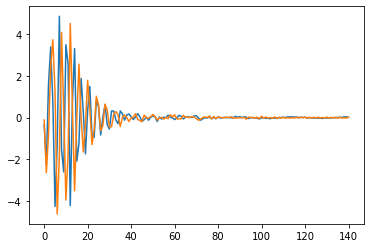

permuted waveform correlations :[[ 1.00714286 -0.32863949]
 [-0.32863949  1.00714286]]  
permuted waveform dct correlations :[[ 1.00704519 -0.3289205 ]
 [-0.3289205   1.00634542]]  


In [76]:
permute_idx = np.concatenate((np.arange(130,141),np.arange(130)))
print(permute_idx)

for i in range(1):
    j = i+1
    wf_test = standardise_wf(waveforms[i:j,:])
    correlations = wf_correlation(0,wf_test)

    permuted = wf_test[0,permute_idx]
    plt.plot(permuted)
    plt.plot(wf_test[0,:])
    plt.show()
    
    
    permuted_ = np.concatenate((wf_test,permuted.reshape(1,141)),axis=0)
    
    dct_wf = fft.dst(permuted_,norm='ortho')
    plt.plot(dct_wf[1,:])
    plt.plot(dct_wf[0,:])
    plt.show()
    
    perm_correlations_dct = wf_correlation([0,1],dct_wf)
    
    perm_correlations = wf_correlation([0,1],permuted_)

    print(f'permuted waveform correlations :{perm_correlations}  ')
    print(f'permuted waveform dct correlations :{perm_correlations_dct}  ')



The desctrete cosine transform does not seem to fulfill translation-invariance..

---
# Looking more into test-statistic
---
Consider waveform $x_c$. Then calculate probability of observation $x$ assuming $x \sim N(\mu_x,I)$ under $H_0: \mu_x = x_c$ in

1000


/Users/Gabriel/miniconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


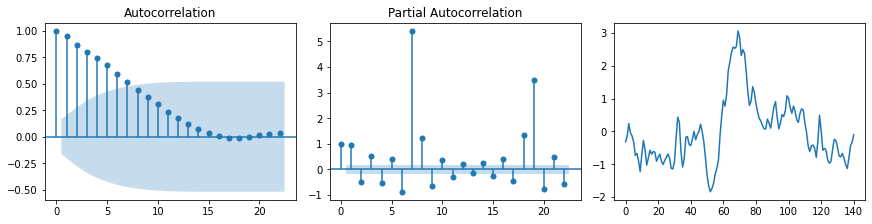

1300


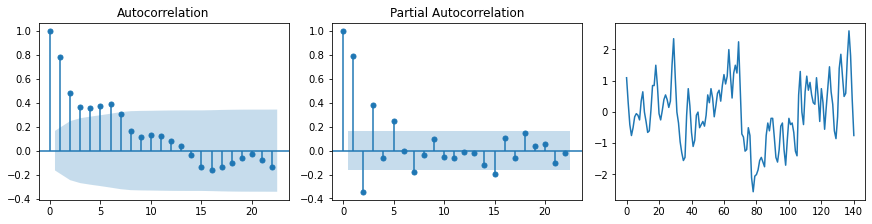

1600


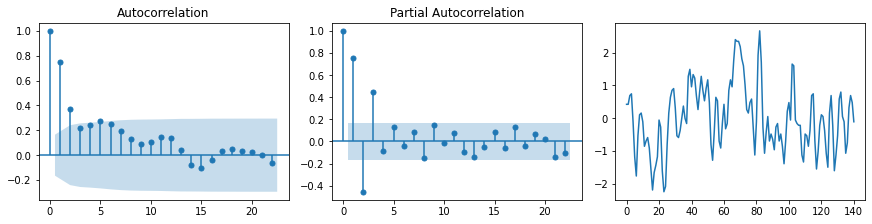

1900


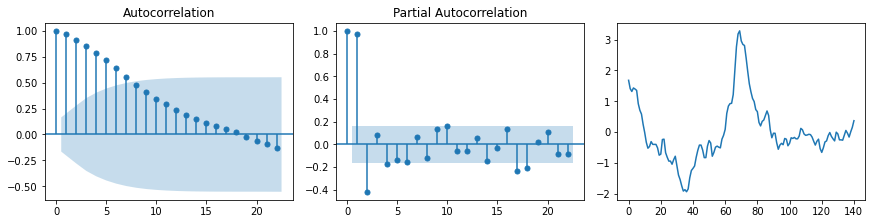

In [66]:
# Assming we have loaded the standardised waveforms : std_waveforms
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#import matplotlib.gridspec as gridspec

i=0

for j in range(1000,2000,300):
    fig, (ax0, ax1, ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize=(12,3))
    print(j)
    #ax.plot(t, y)
    plot_acf(std_waveforms[j,:],ax=ax0)
    
    #ax1.acorr(std_waveforms[j,:]) #,ax=ax1)
    plot_pacf(std_waveforms[j,:],ax=ax1)
    #plt.subplot(9,2,i*2+2)
    ax3.plot(std_waveforms[j,:])
    i+=1
    plt.show()

Clearly significant acf-coeficients for some wavefroms. More noisy signals is starting to resemble more of a white noise.

---
# Probabilities of observed waveforms under H0:
---

In [67]:
from scipy import stats
c = 10
test_stat = std_waveforms - std_waveforms[c,:]
print(test_stat.shape)
mean = np.zeros((test_stat.shape[-1]))
var = np.eye(test_stat.shape[-1])
probs = stats.multivariate_normal.pdf(test_stat,mean,var)*1e57

(136259, 141)


The probabilities of the observed waveforms assuming $x \sim N(\mu_x=x_c,I)$ are originally in the order of magnitude $10^{-100}$...

Number of waveforms above threshold for wf_idx=10 : 20.


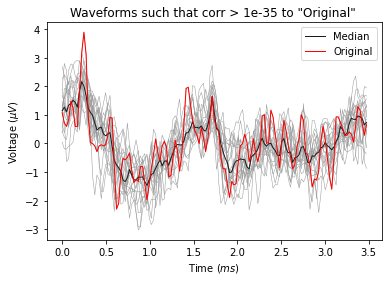

In [68]:
bool_labels = probs>1e-25
#sum(bool_labels)
plot_correlated_wf(i_test,std_waveforms,bool_labels,1e-35,saveas=None,verbose=True )

---
# Similarity measure using LNN to avoid curse of dimensionallity of high dim Gaussian..
---

In [92]:
# std_waveforms given.


def similarity_SSQ(candidate_idx, waveforms, epsilon=0.1, var=1):
    '''
    Similarity measure of waveforms. Based on Annulus theorem of Gaussians.
    That is, a n-dimensional spherical gaussian has all but at most 3*exp{−cnε^2} 
    of the probability mass in the annulus: n(1−ε) <= ||x|| <= n(1+ε). for some fixed constant c.
    
    Parameters
    ----------
    candidate_idx : integer
        ...
    wavefroms : (num_of_wf, dim_of_waveforms) array_like
        
    epsilon : float
        parameter for test-statistic.. ish
    '''
    n = waveforms.shape[1]
    upper_buond = 3*np.exp(-n*(epsilon**2))


    mean_shifted = waveforms - waveforms[candidate_idx,:] # Mean shifted
    candidate_standardised = mean_shifted / var # All elements now assumed to be iid N(0,var)
    print(candidate_standardised.shape)
    # Sum of Squares:
    ssq = np.sum(np.square(candidate_standardised),axis=1) # Under H0, we should have: (n(1-epsilon) < ssq < n(1+epsilon)), with prob. = 1 as n --> inf.
    similarity_evaluation = (n*(1-epsilon) < ssq ) & ( ssq < n*(1+epsilon)) # Those waveform s.t. ssq/sqrt(n) is close to 1 is assumed to be in the same cluster..
    return similarity_evaluation, upper_buond
candidate_idx = 1313
waveforms = std_waveforms
epsilon=0.1
var=1

n = waveforms.shape[0]
mean_shifted = waveforms - waveforms[candidate_idx,:] # Mean shifted
candidate_standardised = mean_shifted / var # All elements now assumed to be iid N(0,1)
# Sum of Squares:
ssq = np.sum(np.square(candidate_standardised),axis=1) # Under H0, we should have: (sqrt(n)(1-epsilon) < ssq < sqrt(n)(1+epsilon)), with prob. = 1 as n --> inf.
similarity_evaluation = (np.sqrt(n)*(1-epsilon) < ssq ) & ( ssq < np.sqrt(n)*(1+epsilon)) # Those waveform s.t. ssq/sqrt(n) is close to 1 is assumed to be in the same cluster..



In [82]:
np.var(std_waveforms[2,:])

1.0000000000000002

(136259, 141)
0.010658605218664066
Number of waveforms above threshold for wf_idx=0 : 403.


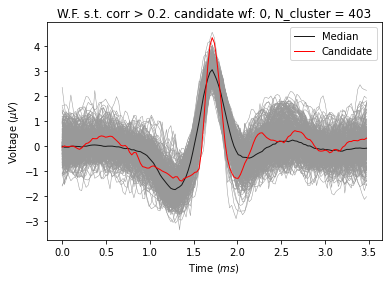

(136259, 141)
0.010658605218664066
Number of waveforms above threshold for wf_idx=21 : 3.


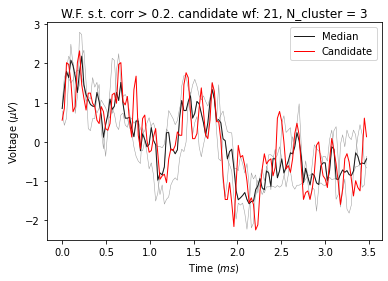

(136259, 141)
0.010658605218664066
Number of waveforms above threshold for wf_idx=130000 : 314.


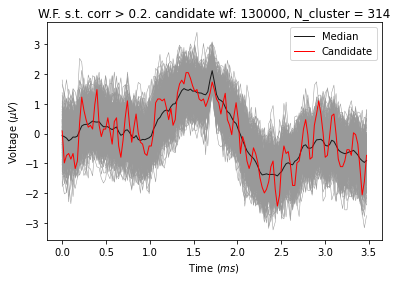

(136259, 141)
0.010658605218664066
Number of waveforms above threshold for wf_idx=1313 : 141.


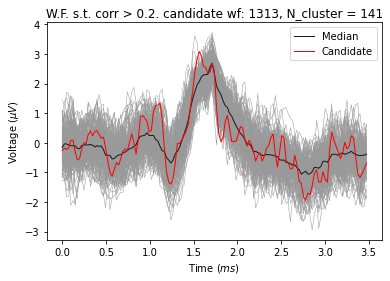

In [99]:
from plot_functions_wf import plot_correlated_wf
eps = 0.2
for candidate_idx in [0,21,130000,1313]:
    bool_labels,upper_buond = similarity_SSQ(candidate_idx, std_waveforms, epsilon=eps, var=0.7)
    print(upper_buond)
    plot_correlated_wf(candidate_idx,std_waveforms,bool_labels,eps,saveas=None,verbose=True )

0
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=0 : 3383.


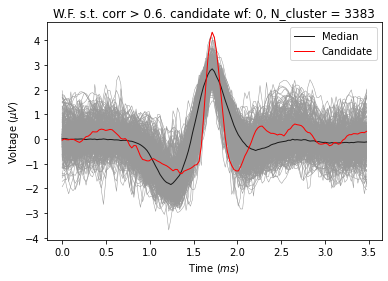

21
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=21 : 147.


../event_rate_first.py:126: UserWarning: No timestamps given to "delta_ev_measure()". Assumes full time of recording.
  warnings.warn('No timestamps given to "delta_ev_measure()". Assumes full time of recording.')


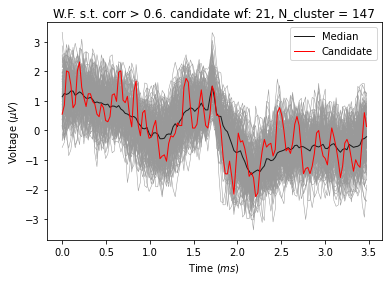

130000
The event_rate_label is : [[0.]
 [1.]
 [0.]]

Number of waveforms above threshold for wf_idx=130000 : 5644.


../event_rate_first.py:126: UserWarning: No timestamps given to "delta_ev_measure()". Assumes full time of recording.
  warnings.warn('No timestamps given to "delta_ev_measure()". Assumes full time of recording.')


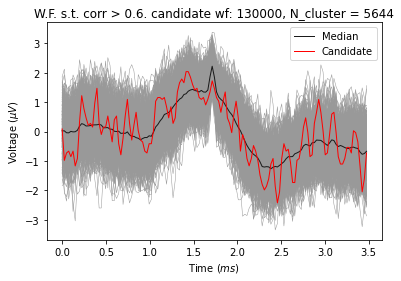

1313
The event_rate_label is : [[0.]
 [0.]
 [1.]]

Number of waveforms above threshold for wf_idx=1313 : 4902.


../event_rate_first.py:126: UserWarning: No timestamps given to "delta_ev_measure()". Assumes full time of recording.
  warnings.warn('No timestamps given to "delta_ev_measure()". Assumes full time of recording.')


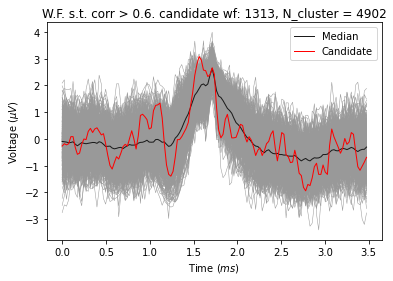

In [88]:
threshold = 0.6
for i in [0,21,130000,1313]:
        print(i)
        correlations = wf_correlation(i,std_waveforms)
        bool_labels = label_from_corr(correlations,threshold=threshold,return_boolean=True )
        event_rates, real_clusters = get_event_rates(timestamps,bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates)
        ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        print(f'The event_rate_label is : {ev_labels}')
        print()
        plot_correlated_wf(i,std_waveforms,bool_labels,threshold,saveas=None,verbose=True )